COMP 215 - LAB 4 (Graphs)
-------------------------
#### Name: David Lu
#### Date: 8 Feb

This lab exercise is an introduction to Graphs and Graph Analysis using [NetworkX](https://networkx.org/documentation/stable/).

**New Python concepts**:
  * **NetworkX** is an open-source package.  It provides a `Graph` object to represent a graph.
  * Built-in `random` module provides algorithms for generating pseudo-random sequences
  * [Generator expression](https://towardsdatascience.com/understanding-generator-expressions-in-python-fe0c4534619) - similar to a list comprehension, but faster and using much less memory!

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [ ]:
%matplotlib inline

import math
import random
from timeit import timeit

import matplotlib.pyplot as plt
import networkx as nx

## ER Graph algorithms.

from the textbook...
> One of the more interesting \[random graphs\] is the Erdős-Rényi model, studied by Paul Erdős and Alfréd Rényi in the 1960s.

> An Erdős-Rényi graph (ER graph) is characterized by two parameters: $n$ is the number of nodes and $p$ is the probability that there is an edge between any two nodes.

> Erdős and Rényi studied the properties of these random graphs; one of their surprising results is the existence of abrupt changes in the properties of random graphs as random edges are added.

In this lab we will work towards re-producing this famous computational experiment.

We can start will all the code we developed in class.
Review development of these algorithms in teh `week04-graphs` workbook.

We `seed` Python's built-in random number generator so we get the same sequence each time (to facilitate debugging and comprehension!)  Comment this out and re-run the notebook when you are ready to run experiments.

In [ ]:
random.seed(6) # Comment this out to run randomized experiments

In [ ]:
def all_pairs(objects):
    """ Return a generator with the complete set of distinct object pairs, as 2-tuples, from the given iterable of objects """
    return ((a, b) for i in range(1, len(objects)) for a,b in zip(objects, objects[i:]))

# unit tests
assert set( all_pairs(('w', 'x', 'y', 'z')) ) == {('w', 'x'), ('x', 'y'), ('y', 'z'), ('w', 'y'), ('x', 'z'), ('w', 'z')}

In [ ]:
def coin_toss(p=0.5):
    """ Simulate flipping a biased "coin", where the probability of 'heads' is p.  Return True iff 'heads', False otherwise """
    return random.random() < p

In [ ]:
def random_pairs(objects, p=0.5):
    """ Return a generator of random subset of distinct object pairs (2-tuples), each with a probability of `p` """
    return (pair for pair in all_pairs(objects) if coin_toss(p))  # "flip a coin" to determine whether a given pair is included.

# Notice: no way to automate tests for random functions because they produce "side-effects" !!!
list( random_pairs(('w', 'x', 'y', 'z'), p=0.5) )

[('y', 'z'), ('w', 'y'), ('x', 'z')]

In [ ]:
def make_random_graph(n, p):
    """ Return an ER Graph with n nodes, where the probability of an edge between a pair of nodes in p """
    graph = nx.Graph()
    labels = range(n)
    graph.add_nodes_from(labels)
    graph.add_edges_from(random_pairs(labels, p))
    return graph

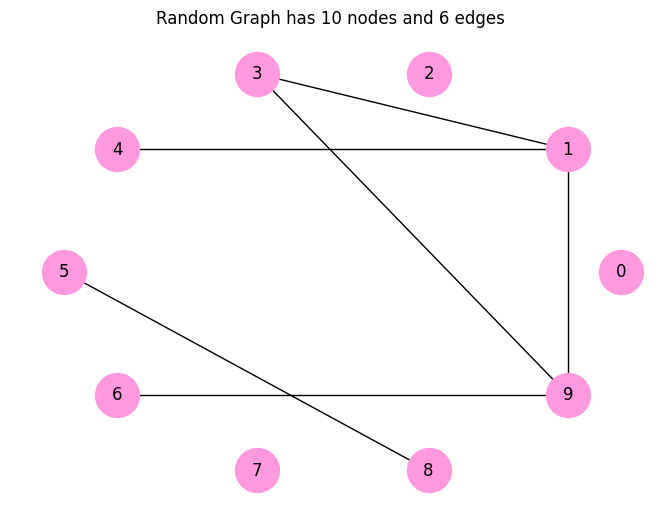

In [ ]:
N = 10
p = 0.2

random_graph = make_random_graph(N, p)

nx.draw_circular(random_graph,
                 node_color='#ff99dd',
                 node_size=1000,
                 with_labels=True)
plt.gca().set(
    title=f'Random Graph has {random_graph.number_of_nodes()} nodes and {random_graph.number_of_edges()} edges'
)
plt.show()

In [ ]:
def reachable_nodes(graph, start):
    """ return the set of nodes that are reachable from the given start node"""
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(graph.neighbors(node))
    return seen

In [ ]:
def is_connected(graph):
    """ Return True if the graph is connected, false otherwise. """
    start = next(iter(graph))   # grab the first node in the graph.  This statement will need some further explanation.
    reachable = reachable_nodes(graph, start)
    return len(reachable) == len(graph)

In [ ]:
is_connected(random_graph)

False

## Lab Exercises

### Exercise 1
Use `timeit` to run an experiment that times the `reachable_nodes` algorithm.
Once you understand how `timeit` works, design a small experiment to time the `reachable_nodes` algorithm for a range of graph sizes (`n`)
Plot the results of your experiment, where x = graph size (`n`) and y = avg. execution time in seconds

In [ ]:
# here's an example of how to use timeit:
N = 100
p = 1
g = make_random_graph(N, p)  # when p=1, this is a complete graph!
seconds = timeit(lambda: reachable_nodes(g,  0),  number=3)
f'Avg. time to execute: {seconds} seconds'

'Avg. time to execute: 0.005653987999721721 seconds'

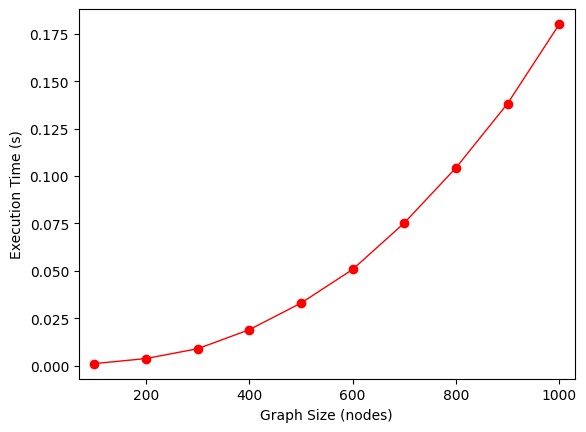

In [ ]:
# Ex. 1 your code here...

num_runs = 50  # May take a while... try 50 if running slowly

num_nodes = [i for i in range(100, 1100, 100)]  # a.k.a Graph size
random_graphs = [make_random_graph(size, p) for size in num_nodes]
exec_times_by_run = [0] * num_runs

for i in range(num_runs):

    exec_times_by_run[i] = [timeit(lambda: reachable_nodes(graph, 0), number = 1)
                    for graph in random_graphs]

times_by_num_nodes = zip(*exec_times_by_run)
time = [sum(times)/num_runs for times in times_by_num_nodes]  # average time for each increment of nodes

x_pad = 30
y_pad = x_pad * (time[-1] - time[0])/900 * 6.4/4.8

x_min = 100 - x_pad
x_max = 1000 + x_pad
y_min = time[0] - y_pad
y_max = time[-1] + y_pad

plt.plot(num_nodes, time, 'o-r', linewidth = 1)
plt.axis((x_min, x_max, y_min, y_max))
plt.xlabel('Graph Size (nodes)')
plt.ylabel('Execution Time (s)')
plt.show()

### Exercise 2:
What is the **Big-O time complexity** of the `reachable_nodes` algorithm?

#### Ex. 2 Your Answer: $O(n^2)$


## Likelihood of connectivity

We are ready to replicate Erdős and Rényi's computational experiment.
In this experiment, we estimate the likelihood that a randomly-generated ER graph is connected.

Like most computational experiments, we simple "brute force" the solution - create a big pile of ER graphs, and simply count up how many of them are connected.

### Exercise 3:
Write a function that runs one ER experiment for a given value of $n$ and $p$.

The function generates `n_trials` (number of trials) graphs and returns the proportion of them that are connected.

In [ ]:
def proportion_connected(n, p, n_trials=100):
    """ Return the proportion of random ER Graphs (n, p) that are connected out of n trials. """
    # Ex. 3 your code here here...
    # Step 1: make n_trials random graphs

    n_random_graphs = [make_random_graph(n, p) for trial in range(n_trials)]

    # Step 2: compute the proportion of those graphs that are connected

    num_connected = 0

    for graph in n_random_graphs:

        if is_connected(graph):

            num_connected += 1

    return num_connected/n_trials


n = 30
p = 0.1
p_connected = proportion_connected(n, p)*100  # percentage
f'Likelihood that an ER graph (n={n}, p={p}) is connected: {p_connected:.1f}%'

'Likelihood that an ER graph (n=30, p=0.1) is connected: 19.0%'

### Exercise 4:
Use `timeit` to determine how much time each experimental run is consuming.  
Plot the results of your experiment, where x = number of trials (`n_trials`) and y = avg. execution time in seconds

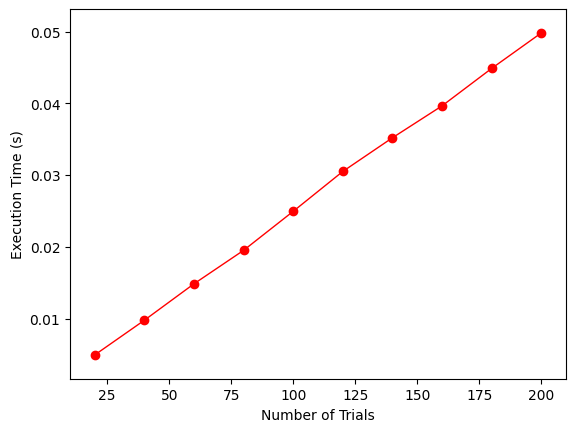

In [ ]:
# Solution for Ex. 4 here...

num_runs = 80  # More runs = more reliable average time result

num_trials = [i for i in range(20, 220, 20)]
exec_times = [0] * num_runs

for i in range(num_runs):

    exec_times[i] = [timeit(lambda: proportion_connected(n, p, n_trials = num), number = 1)
                    for num in num_trials]

times_by_num_trials = zip(*exec_times)  # Repackage list
time = [sum(times)/num_runs for times in times_by_num_trials]

x_pad = 10
y_pad = x_pad * (time[-1] - time[0])/180 * 6.4/4.8

x_min = 20 - x_pad
x_max = 200 + x_pad
y_min = time[0] - y_pad
y_max = time[-1] + y_pad

# y_max = avg_exec_time[-1] + avg_exec_time[0]

plt.plot(num_trials, time, 'o-r', linewidth = 1)
plt.axis((x_min, x_max, y_min, y_max))
plt.xlabel('Number of Trials')
plt.ylabel('Execution Time (s)')
plt.show()

### Exercise 5:
Our experimental results are more accurate (i.e., show less variation between runs) when we use large values for `n` and `n_trials`.  But we've seen that large values for these 2 inputs can cause serious performance issues.

What are reasonable value for `n` and `n_trials` to use in the experimental setup below?

#### Your Answer:


## Critical Value of $p$

Near a "critical value" of $p$, the likelihood of a random graph being connected rapidly changes from near 0 to near 1.
Erdős and Rényi predict the critical value should be:  $ln(n) / n$
For example...

In [ ]:
n = 30
f'Erdős and Rényi predict the critical value of p for graphs of size {n} = {math.log(n) / n:0.3f}'

'Erdős and Rényi predict the critical value of p for graphs of size 30 = 0.113'

### Exercise 6:
Develop an experiment using `proportion_connected` that runs trials over a range of values for $p$.
The goal of this experiment is to identify the "critical value" of $p$ for graphs of size $n$.

You can conduct this experiment by hand by manually running the code above with different input values and record your results in Ex. 7, ... or

#### Challenge - Take your skills to the next level...
Develop the experimental setup in code to run all trials over a range of values for $p$ and then plot the results of your experiment, where x = value of `p` and y = proportion connection in the experimental run

critical value: 0.11337324605540518
Edge Probabilities
['0.043', '0.000', '0.057', '0.000', '0.071', '0.000', '0.085', '0.000', '0.099', '0.000', '0.113', '0.000', '0.127', '0.000', '0.141', '0.000', '0.155', '0.000', '0.169', '0.000', '0.183']
Connected Graph Probabilities
['0.000', '0.000', '0.002', '0.000', '0.021', '0.000', '0.090', '0.000', '0.220', '0.000', '0.391', '0.000', '0.553', '0.000', '0.704', '0.000', '0.794', '0.000', '0.865', '0.000', '0.916']
Curvature of Connected Graph Probabilities
['2: 0.0170', '4: 0.0497', '6: 0.0620', '8: 0.0403', '10: 0.0090', '12: 0.0117', '14: 0.0603', '16: 0.0187', '18: 0.0203']
Curvature of Connected Graph Probabilities, Sorted
['6: 0.0620', '14: 0.0603', '4: 0.0497', '8: 0.0403', '18: 0.0203', '16: 0.0187', '2: 0.0170', '12: 0.0117', '10: 0.0090']
Location: 6, Increment: 0.085
0.078, 0.092
0.054, 0.159
Location: 14, Increment: 0.141
0.134, 0.148
0.638, 0.763
New Edge Probabilities
['0.043', '0.000', '0.057', '0.000', '0.071', '0.078', '0.0

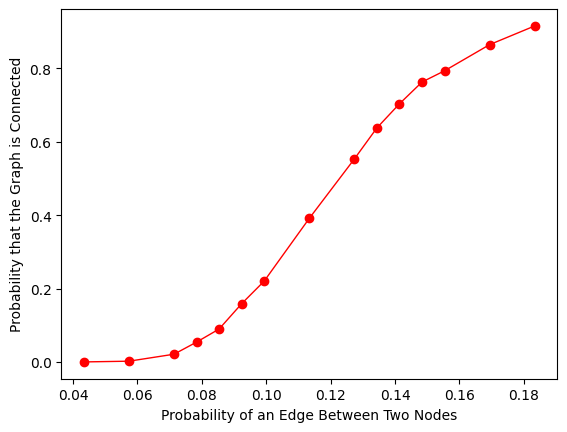

In [ ]:
# Ex. 6 (challenge) your code here...

num_nodes = 30
num_trials = 3000  # 3000 / 1000 / 300

critical_value = math.log(num_nodes) / num_nodes  # value to be verified
print(f'critical value: {critical_value}')

# Convoluted Two-Step Process

num_increment_initial = 11
num_increment_supplemental = 4

reserve = 2 * num_increment_initial - 1

increments = [0] * reserve

for index in range(reserve):

    halfway = math.floor(reserve / 2)

    if index % 2 == 0:

        if index == halfway:

            increments[index] = critical_value

        else:

            increments[index] = critical_value - 0.007 * (halfway - index)

connectivity = [proportion_connected(num_nodes, inc, num_trials) for inc in increments]

print('Edge Probabilities')
print([f'{inc:.3f}' for inc in increments])
print('Connected Graph Probabilities')
print([f'{conn:.3f}' for conn in connectivity])

curvature = [0] * (num_increment_initial - 2)

for i in range(2, 19, 2):

    last_step = connectivity[i] - connectivity[i-2]
    next_step = connectivity[i+2] - connectivity[i]

    delta = next_step - last_step

    curvature[int(i/2)-1] = (i, abs(delta))

print('Curvature of Connected Graph Probabilities')
print([f'{curv[0]}: {curv[1]:.4f}' for curv in curvature])

curvature.sort(key = lambda x: x[1], reverse = True)

print('Curvature of Connected Graph Probabilities, Sorted')
print([f'{curv[0]}: {curv[1]:.4f}' for curv in curvature])

num_pairs_supplemental = int(num_increment_supplemental / 2)
locations_to_insert = [curv[0] for curv in curvature[:num_pairs_supplemental]]

for loc in locations_to_insert:

    print(f'Location: {loc}, Increment: {increments[loc]:.3f}')

    supplemental_low = (increments[loc-2] + increments[loc]) / 2
    supplemental_high = (increments[loc] + increments[loc+2]) / 2

    print(f'{supplemental_low:.3f}, {supplemental_high:.3f}')

    supp_conn_low = proportion_connected(num_nodes, supplemental_low, num_trials)
    supp_conn_high = proportion_connected(num_nodes, supplemental_high, num_trials)

    print(f'{supp_conn_low:.3f}, {supp_conn_high:.3f}')

    increments[loc-1] = supplemental_low; increments[loc+1] = supplemental_high

    if connectivity[loc-1] == 0:

        connectivity[loc-1] = supp_conn_low

    else:

        connectivity[loc-1] = (connectivity[loc-1] + supp_conn_low) / 2

        print(f'Average results: {loc-1}, {connectivity[loc-1]}')

    if connectivity[loc+1] == 0:

         connectivity[loc+1] = supp_conn_high

    else:

        connectivity[loc+1] = (connectivity[loc+1] + supp_conn_high) / 2

        print(f'Average results: {loc+1}, {connectivity[loc+1]}')


print('New Edge Probabilities')
print([f'{inc:.3f}' for inc in increments])
print('New Connected Graph Probabilities')
print([f'{conn:.3f}' for conn in connectivity])

assert min(increments) >= 0

# Filter out those zeros which initially filled the spaces allocated for
# potential supplementary increments. Take care to not filter out legitimate
# connectivity probability data just because it is zero.

zero_filter = [inc == 0 for inc in increments]
finalised_increments = [inc for inc, is_zero in zip(increments, zero_filter) if is_zero == False]
finalised_connectivity = [conn for conn, is_zero in zip(connectivity, zero_filter) if is_zero == False]

print('Finalised Edge Probabilities')
print([f'{inc:.3f}' for inc in finalised_increments])
print('Finalised Connected Graph Probabilities')
print([f'{conn:.3f}' for conn in finalised_connectivity])

plt.plot(finalised_increments, finalised_connectivity, 'o-r', linewidth = 1)
# plt.axis((x_min, x_max, y_min, y_max))
plt.xlabel('Probability of an Edge Between Two Nodes')
plt.ylabel('Probability that the Graph is Connected')
plt.show()

### Exercise 7:
Does your experiment confirm or refute Erdős and Rényi's results?

What real-world applications / implications might this understanding of graph connectivity have?

#### Ex. 7 Your Answer:

The experiment confirms Erdos and Renyi's prediction that the chance of a random graph being connected changes most rapidly near a critical edge probability of $\ln(n)/n$. This is demonstrated by the slope of the line in this experiment, which can be seen to reach a maximum near the critical edge probability: $$ p_\text{critical} = \frac{\ln{30}}{30} \approx 0.113 $$

There are many possible applications of this understanding of graph connectivity. For example, it can inform decisions about the level of redundency that should be built into electrical, communications, or transportation networks, taking into consideration the reliability of the connection between two neighbouring points of interest. Although, I'm not sure whether the Erdos-Renyi model would be best suited for such real-life applications.
